## Setup: imports

We only use Python stdlib + NumPy + Matplotlib.  
One figure per plot, no seaborn, no style tweaks (to keep outputs simple and consistent).


In [1]:
import math
import random
from typing import List, Iterable, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt

## Shared toy landscape and neighbor rule (used in Q2, Q3)

We reproduce the assignment’s toy domain exactly:

* **Objective (minimize):**  $Eval(X)=|X-800|$  (global minimizer at $X=800$).

* **Move set:**
$$
MoveSet(X)=
\begin{cases}
\{1\}, & X=0 \\
\{999\}, & X=1000 \\
\{X-1, X+1\}, & \text{otherwise}
\end{cases}
$$

These functions will be reused by Hill Climbing and Simulated Annealing later.


In [2]:
def eval_abs800(x: int) -> int:
    return abs(x - 800)


def moves_0_1000(x: int) -> List[int]:
    if x == 0:
        return [1]
    if x == 1000:
        return [999]
    return [x - 1, x + 1]

## Plot helper

A simple function to visualize the landscape $|X-800|$ and overlay a trajectory of visited states.


In [3]:
def plot_trajectory(path: List[int], title: str = ""):
    xs = np.arange(0, 1001)
    ys = np.abs(xs - 800)
    plt.figure()
    plt.plot(xs, ys)
    plt.scatter(path, [eval_abs800(u) for u in path])
    plt.title(title or "Trajectory")
    plt.xlabel("X")
    plt.ylabel("Eval(X) = |X - 800|")
    plt.show()

## Algorithm: Hill Climbing

**Idea:** Move to the neighbor with **lower** $Eval(X)$, stopping when no better neighbor exists  
(local optimum or plateau).

**GLS parameters:**  
`maxIter=1`, `numInd=1`, `schedule(t)=0`, `rsFlag=F`, `swniFlag=T`.


In [4]:
def hill_climb(start: int, max_steps: int = 2000) -> Tuple[int, List[int]]:
    """Greedy hill climbing to MAXIMIZE Eval."""
    x = start
    path = [x]
    for _ in range(max_steps):
        nbrs = moves_0_1000(x)
        best = max(nbrs, key=eval_abs800)   # maximize
        if eval_abs800(best) > eval_abs800(x):
            x = best
            path.append(x)
        else:
            break
    return x, path

## Algorithm: Random Walk

Always move to a random neighbor, ignoring the evaluation.  
Behaves like a very “hot” simulated annealing process (when $r>1$).


In [5]:
def random_walk(start: int, steps: int = 200, rng: Optional[random.Random] = None) -> Tuple[int, List[int]]:
    rng = rng or random.Random()
    x = start
    path = [x]
    for _ in range(steps):
        x = rng.choice(moves_0_1000(x))
        path.append(x)
    return x, path

## Algorithm: Simulated Annealing (geometric cooling)

Simulated annealing occasionally accepts *worse* moves to escape local minima.

Acceptance rule for a proposed move $X \to X'$ with costs $E = Eval(X)$ and $E' = Eval(X')$:

$$
P(\text{accept worse}) = e^{-\frac{E' - E}{T}}
$$

Cooling schedule (geometric):  $T_{t+1} = rT_t$  with $0 < r < 1$.

**Special cases:**
- $r = 0$ → immediate freeze → behaves like hill climbing  
- $r > 1$ → heating up → behaves like random walk


In [6]:
def simulated_annealing(
    start: int,
    T0: float = 1.0,
    r: float = 0.8,
    steps: int = 200,
    rng: Optional[random.Random] = None
) -> Tuple[int, List[int], List[float]]:
    """Simulated annealing to MAXIMIZE Eval; geometric cooling."""
    rng = rng or random.Random()
    x = start
    path = [x]
    temps = [T0]
    T = T0
    for _ in range(steps):
        x2 = rng.choice(moves_0_1000(x))
        E, E2 = eval_abs800(x), eval_abs800(x2)
        if E2 >= E:
            # better (or equal) is always accepted
            accept = True
        else:
            accept = (T > 0) and (rng.random() < math.exp(-(E - E2) / T))
        if accept:
            x = x2
        path.append(x)
        T *= r
        temps.append(T)
    return x, path, temps

## Diagnostic: acceptance rate for worse moves under SA

This function estimates how often simulated annealing accepts *worse* moves  
for given $T_0$ and $r$.  
It’s useful to visualize how different $r$ values ($>1$, $<1$, $=0$) affect behavior.


In [7]:
def acceptance_stats(start: int, T0: float, r: float, trials: int = 500, rng_seed: int = 123) -> float:
    """Fraction of WORSE (lower-score) moves accepted when MAXIMIZING."""
    rng = random.Random(rng_seed)
    x = start
    T = T0
    worse_total = 0
    worse_accepts = 0
    for _ in range(trials):
        x2 = rng.choice(moves_0_1000(x))
        E, E2 = eval_abs800(x), eval_abs800(x2)
        if E2 < E:                                  # worse when maximizing
            worse_total += 1
            p = 0.0 if T <= 0 else math.exp(-(E - E2) / T)
            if rng.random() < p:
                worse_accepts += 1
        x = x2
        T *= r
    return 0.0 if worse_total == 0 else worse_accepts / worse_total

## Beam Search: GENERATE-SUCCESSOR

Given a current beam (list of states) and width $K$:

1. Generate all successors of each state  
2. Sort by $Eval(X)$ (ascending)  
3. Keep the best $K$ as the next beam


In [8]:
def beam_generate_successor(current: Iterable[int], K: int) -> List[int]:
    """Beam step for MAXIMIZATION: keep top-K by score."""
    succs = set()
    for x in current:
        succs.update(moves_0_1000(x))
    return sorted(succs, key=eval_abs800, reverse=True)[:K]

## Full Local Beam Search

In [9]:
def local_beam_search(
    K: int,
    max_iters: int = 50,
    initial: List[int] | None = None,
    rng_seed: int | None = None,
    goal_score: int = 800,
    use_random_restart_on_stall: bool = True,
):
    """
    Run Local Beam Search to MAXIMIZE Eval(X)=|X-800|.
    - K: beam width
    - initial: optional starting beam (list of ints). If None, choose K random states in [0,1000].
    - goal: score >= goal_score (800) i.e., X=0
    - returns: (final_beam, history)
    """
    rng = random.Random(rng_seed) if rng_seed is not None else random

    # 1) initialize beam
    if initial is None:
        current = [rng.randint(0, 1000) for _ in range(K)]
    else:
        current = list(initial[:K]) if len(initial) >= K else list(initial) + \
            [rng.randint(0, 1000) for _ in range(K - len(initial))]

    # normalize order by score (descending) for cleaner diffs/prints
    current = sorted(set(current), key=eval_abs800, reverse=True)[:K]

    history = [current[:]]

    for t in range(max_iters):
        # 2) goal check
        if any(eval_abs800(x) >= goal_score for x in current):
            return current, history  # goal present in beam

        # 3) expand & select best K overall
        next_beam = beam_generate_successor(current, K)

        # 4) detect stagnation (no change in beam)
        if next_beam == current:
            if use_random_restart_on_stall:
                # replace the worst element with a random state (kick)
                worst_idx = min(range(len(current)),
                                key=lambda i: eval_abs800(current[i]))
                kick = rng.randint(0, 1000)
                current[worst_idx] = kick
                current = sorted(
                    set(current), key=eval_abs800, reverse=True)[:K]
                history.append(current[:])
                continue
            else:
                return current, history  # stop if we don't want restarts

        current = next_beam
        history.append(current[:])

    return current, history

## GA utilities: probability of already having an optimal individual

If each genome is optimal with probability $p$ and population size is $N$:

$$
P(\text{≥1 optimal}) = 1 - (1 - p)^N, \quad E[\#optimal] = Np
$$

We’ll use $p = \frac{1}{256}$ and $N = 1000$ as in the question.


In [10]:
def ga_init_probability(pop_size: int = 1000, optimal_rate: float = 1/256) -> Tuple[float, float]:
    p_any = 1 - (1 - optimal_rate) ** pop_size
    expected = pop_size * optimal_rate
    return p_any, expected


def monte_carlo_any_optimal(trials=2000, pop_size=1000, optimal_rate=1/256, seed=2025) -> float:
    rng = random.Random(seed)
    hits = 0
    for _ in range(trials):
        if any(rng.random() < optimal_rate for __ in range(pop_size)):
            hits += 1
    return hits / trials

## Q1(a): Map algorithms to GLS parameters

Set the GLS flags and parameters to match each algorithm:

| Algorithm | maxIter | numInd | schedule(t) | rsFlag | tFlag | swniFlag |
|------------|----------|---------|--------------|--------|---------|------------|
| Vanilla Hill Climb | 1 | 1 | 0 | F | F | T |
| Random-Restart Hill Climb | M | 1 | 0 | F | F | T |
| Random Walk | 1 | 1 | +$\infty$ | T | T/F | F |
| Simulated Annealing | 1 | 1 | s(t) | T | T | F |


### Explanation of parameters and flags

This table compares different local-search algorithms using a unified notation.
Each algorithm can be seen as a variant of **hill climbing** that changes a few control parameters.

| Parameter | Meaning |
|------------|----------|
| **maxIter** | Number of independent runs or iterations of the full search. For example, `M` in random-restart hill climbing means the algorithm repeats from different random initial states `M` times. |
| **numInd** | Number of individuals (states) maintained at once. A value of `1` means a single current state (standard hill climb). If greater than `1`, the algorithm keeps a population (e.g., beam search, GA). |
| **schedule(t)** | The **temperature or noise schedule** over time. It controls how much randomness or exploration is allowed at iteration `t`. <br> - `0`: deterministic (no randomness). <br> - `+∞`: completely random (pure random walk). <br> - `s(t)`: follows a temperature schedule (as in simulated annealing). |
| **rsFlag (random-step flag)** | Whether *random steps* are allowed regardless of improvement. <br> - `T` (True): algorithm may move even if the new state is worse. <br> - `F` (False): only moves to better or equal states. |
| **tFlag (temperature flag)** | Whether a *temperature* (or schedule) is explicitly used to control acceptance of worse moves. <br> - `T`: algorithm’s randomness depends on temperature (simulated annealing). <br> - `F`: no temperature term (hill climbing or random walk). |
| **swniFlag (stop-when-no-improvement flag)** | Whether the algorithm **terminates** when no better neighbor is found. <br> - `T`: stop if no improvement (hill climbing). <br> - `F`: continue regardless (random walk, SA). |

#### Interpretation of each row

| Algorithm | Interpretation |
|------------|----------------|
| **Vanilla Hill Climbing** | A single climb that only accepts better moves. Stops when no improvement is possible. |
| **Random-Restart Hill Climbing** | Same as vanilla hill climbing, but run `M` times from different random start points; keeps the best result. |
| **Random Walk** | Always takes a random step, ignoring fitness (pure exploration). Temperature is effectively infinite; never stops on local maxima. |
| **Simulated Annealing** | A probabilistic hill climber: sometimes accepts worse moves depending on a decreasing temperature `s(t)` (the annealing schedule). |

In short:
- **Hill climbing**: deterministic, greedy.  
- **Random walk**: completely random.  
- **Simulated annealing**: transitions smoothly between the two by cooling down over time.


### Q1(a) — What the GLS table shows
Our table encodes: Hill Climb (1 state, schedule=0, stop-on-no-improvement), Random-Restart HC (repeat M times),
Random Walk (random successor, “infinite” temperature, don’t stop on no-improvement), and Simulated Annealing (random successor + cooling).
It demonstrates how these algorithms are parameterizations of a single GLS meta-procedure.


## Q1(b): Beam Search – GENERATE-SUCCESSOR demo

For each state in the beam, generate all successors and select the **best $K$**  
according to $Eval(X)$.  
The demo below shows this behavior for a sample beam.


In [11]:
beam_current = [100, 500, 900]

K = 5
next_beam = beam_generate_successor(beam_current, K)
print("Beam Search demo:")
print(" current =", beam_current)
print(" next =", next_beam)

Beam Search demo:
 current = [100, 500, 900]
 next = [99, 101, 499, 501, 901]


### Q1(b) — Beam Search result (why these K states?)
Beam = [100, 500, 900], K=5 → next = [99, 101, 499, 501, 901].
Scores: |99−800|=701, |101−800|=699, |499−800|=301, |501−800|=299, |901−800|=101.
They’re the highest-score neighbors among all expansions, so they survive the beam prune.


## Local Beam Search: quick runs

Below are two examples:
1) Random initialization (reproducible with a seed)
2) Hand-picked initialization [100, 500, 900]
We print the final beam and the best member with its score.


In [12]:
# 1) random init example
final_beam, hist = local_beam_search(K=5, max_iters=20, rng_seed=444)
best = max(final_beam, key=eval_abs800)
print("Random-init final beam:", final_beam)
print("Best =", best, "Score =", eval_abs800(best), "Iters =", len(hist)-1)

# 2) fixed init example
final_beam2, hist2 = local_beam_search(
    K=5, max_iters=10, initial=[100, 500, 900], rng_seed=7)
best2 = max(final_beam2, key=eval_abs800)
print("Fixed-init final beam:", final_beam2)
print("Best =", best2, "Score =", eval_abs800(best2), "Iters =", len(hist2)-1)

Random-init final beam: [0, 2, 4, 6, 8]
Best = 0 Score = 800 Iters = 13
Fixed-init final beam: [90, 92, 94, 96, 98]
Best = 90 Score = 710 Iters = 10


## Visualizing the beam across iterations

This prints the beam at each iteration and highlights the best member per step.


In [13]:
def print_beam_history(history):
    for t, beam in enumerate(history):
        best = max(beam, key=eval_abs800)
        scores = [eval_abs800(x) for x in beam]
        print(
            f"t={t:2d} beam={beam}  scores={scores}  best={best}({eval_abs800(best)})")


print("=== Random-init beam progression ===")
print_beam_history(hist)

print("\n=== Fixed-init beam progression ===")
print_beam_history(hist2)

=== Random-init beam progression ===
t= 0 beam=[13, 294, 316, 496]  scores=[787, 506, 484, 304]  best=13(787)
t= 1 beam=[12, 14, 293, 295, 315]  scores=[788, 786, 507, 505, 485]  best=12(788)
t= 2 beam=[11, 13, 15, 292, 294]  scores=[789, 787, 785, 508, 506]  best=11(789)
t= 3 beam=[10, 12, 14, 16, 291]  scores=[790, 788, 786, 784, 509]  best=10(790)
t= 4 beam=[9, 11, 13, 15, 17]  scores=[791, 789, 787, 785, 783]  best=9(791)
t= 5 beam=[8, 10, 12, 14, 16]  scores=[792, 790, 788, 786, 784]  best=8(792)
t= 6 beam=[7, 9, 11, 13, 15]  scores=[793, 791, 789, 787, 785]  best=7(793)
t= 7 beam=[6, 8, 10, 12, 14]  scores=[794, 792, 790, 788, 786]  best=6(794)
t= 8 beam=[5, 7, 9, 11, 13]  scores=[795, 793, 791, 789, 787]  best=5(795)
t= 9 beam=[4, 6, 8, 10, 12]  scores=[796, 794, 792, 790, 788]  best=4(796)
t=10 beam=[3, 5, 7, 9, 11]  scores=[797, 795, 793, 791, 789]  best=3(797)
t=11 beam=[2, 4, 6, 8, 10]  scores=[798, 796, 794, 792, 790]  best=2(798)
t=12 beam=[1, 3, 5, 7, 9]  scores=[799, 797

## Q1(b): Genetic Algorithm – GENERATE-SUCCESSOR demo

Main operators:
1. **Selection** – choose parents with probability proportional to fitness  
2. **Crossover** – single-point crossover to mix genes  
3. **Mutation** – bit-flip with rate 0.01

Below: a small demo that generates new offspring from a population of 16-bit strings.


In [14]:
import random
from typing import List, Tuple


def fitness_ones(bitstr: str) -> int:
    """Return the fitness of a bitstring, defined as the number of '1' bits it contains."""
    return bitstr.count("1")


def roulette_select(pop: List[str], fitness_fn, rng: random.Random) -> str:
    """Select one individual from the population using roulette-wheel (fitness-proportional) selection.
    Each individual is chosen with probability proportional to its fitness value."""
    fits = [fitness_fn(x) for x in pop]
    s = sum(fits)
    if s <= 0:
        return rng.choice(pop)
    r = rng.uniform(0, s)
    acc = 0.0
    for x, f in zip(pop, fits):
        acc += f
        if acc >= r:
            return x
    return pop[-1]


def single_point_crossover(a: str, b: str, rng: random.Random) -> Tuple[str, str]:
    """Perform single-point crossover between two parent bitstrings.
    A random cut point is selected, and the tails of the two parents are swapped."""
    if len(a) < 2:
        return a, b
    cut = rng.randint(1, len(a) - 1)
    return a[:cut] + b[cut:], b[:cut] + a[cut:]


def mutate_bitflip(x: str, rate: float, rng: random.Random) -> str:
    """Mutate a bitstring by flipping each bit with independent probability equal to 'rate'."""
    bits = list(x)
    for i in range(len(bits)):
        if rng.random() < rate:
            bits[i] = "1" if bits[i] == "0" else "0"
    return "".join(bits)


def ga_generate_successor(pop: List[str], mutation_rate=0.01, rng: random.Random | None = None) -> List[str]:
    """Generate a new population (next generation) using a genetic algorithm.
    Each generation:
      1. Selects two parents using roulette-wheel selection.
      2. Produces two children by single-point crossover.
      3. Applies bit-flip mutation to each child.
    The function returns a list of children equal in size to the input population."""
    rng = rng or random.Random()
    N = len(pop)
    children: List[str] = []
    for _ in range(N // 2):
        p1 = roulette_select(pop, fitness_ones, rng)
        p2 = roulette_select(pop, fitness_ones, rng)
        c1, c2 = single_point_crossover(p1, p2, rng)
        children.append(mutate_bitflip(c1, mutation_rate, rng))
        children.append(mutate_bitflip(c2, mutation_rate, rng))
    if len(children) < N:
        children.append(rng.choice(children))
    return children[:N]



# Demo
random.seed(0)
pop0 = ["".join(random.choice("01") for _ in range(16)) for _ in range(10)]
pop1 = ga_generate_successor(pop0, mutation_rate=0.01)
print("pop0[0] ->", pop0[0])
print("pop1[0] ->", pop1[0])

for i, (p0, p1) in enumerate(zip(pop0, pop1)):
    print(f"{i:2d}: {p0}  →  {p1}")

pop0[0] -> 1101111110010010
pop1[0] -> 1000000000000101
 0: 1101111110010010  →  1000000000000101
 1: 1001101110111000  →  1101011000110100
 2: 1011010000010011  →  1101011000100111
 3: 0110101101101000  →  0110000001100101
 4: 0110000001100111  →  1101011000100101
 5: 1101011000100101  →  1101011000100101
 6: 1000000000010100  →  1101001111110010
 7: 0000100010100011  →  1101001111110010
 8: 1001001011100000  →  1001001011100000
 9: 1101001111110010  →  1000000000010100


### Q1(b) — GA offspring sanity check
`pop0[0] = 1101111110010010` → `pop1[0] = 1011011110010010`.
This looks like a single-point crossover product plus potential single-bit flips (mutation rate 0.01).


## Q2(a–c): Simulated Annealing schedule and acceptance (concept)

- $r > 1$: temperature rises → accepts almost all worse moves → behaves like **random walk**  
- $0 < r < 1$: gradual cooling → early exploration, late exploitation  
- $r = 0$: freezes instantly → no worse moves → behaves like **hill climbing**

Also, changing the acceptance test to `if exp(-(E - E')/T) > z` doesn’t change behavior.


## Q2(a–c): Empirical acceptance rate test

We estimate the fraction of worse moves accepted by SA for:
- $r = 1.1$ (increasing $T$),
- $r = 0.8$ (normal cooling),
- $r = 0$ (frozen).

These numerical results confirm the conceptual discussion.


In [15]:
acc_r_gt_1 = acceptance_stats(start=500, T0=1.0, r=1.1, trials=1000)
acc_r_mid = acceptance_stats(start=500, T0=1.0, r=0.8, trials=1000)
acc_r_eq_0 = acceptance_stats(start=500, T0=1.0, r=0.0, trials=1000)
print("Accept worse (r=1.1):", acc_r_gt_1)
print("Accept worse (r=0.8):", acc_r_mid)
print("Accept worse (r=0.0):", acc_r_eq_0)

Accept worse (r=1.1): 0.9896049896049897
Accept worse (r=0.8): 0.002079002079002079
Accept worse (r=0.0): 0.0


### Q2(a–c) — What the acceptance rates show
• r=1.1 (hot): accept worse ≈ 0.990 → random-walk-like.  
• r=0.8 (cooling): accept worse ≈ 0.002 → mostly greedy after cooling.  
• r=0.0 (frozen): accept worse = 0.000 → hill-climb behavior.  
The parameter $r$ controls the tradeoff between exploration and exploitation in simulated annealing.

## Q2(d): Hill Climbing from $X = 900$

We start at $X=900$ and let hill climbing run.  
Observe that it moves toward smaller Eval(X) values until no improvement is possible.


Hill Climb from 900 -> final X=1000, Eval=200, steps=100


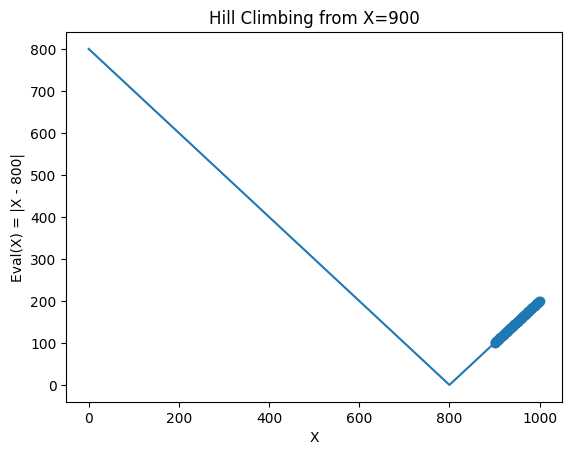

In [16]:
hc_final, hc_path = hill_climb(900, max_steps=500)
print(
    f"Hill Climb from 900 -> final X={hc_final}, Eval={eval_abs800(hc_final)}, steps={len(hc_path)-1}")
plot_trajectory(hc_path, "Hill Climbing from X=900")

### Q2(d) — Hill Climb result
Start at X=900 → final X=1000, score=200, steps=100.
Interpretation: greedy ascent heads right and gets stuck in the local maximum at X=1000 (score 200), not the global maximum X=0 (score 800).


## Q2(e): Simulated Annealing from $X=900$, $T_0=1$, $r=0.8$

Run SA for 200 steps and plot the path.  
Compute $T_{20} = 1 * 0.8^{20} ≈ 0.0115$ and $T_{200} ≈ 4.15×10^{-20}$.

After about 20 steps, $T$ is so low that no worse moves are accepted —  
the algorithm effectively becomes hill climbing and stops in the local optimum.


SA from 900 (T0=1, r=0.8) -> final X=1000, Eval=200, steps=600, final T=7.145e-59


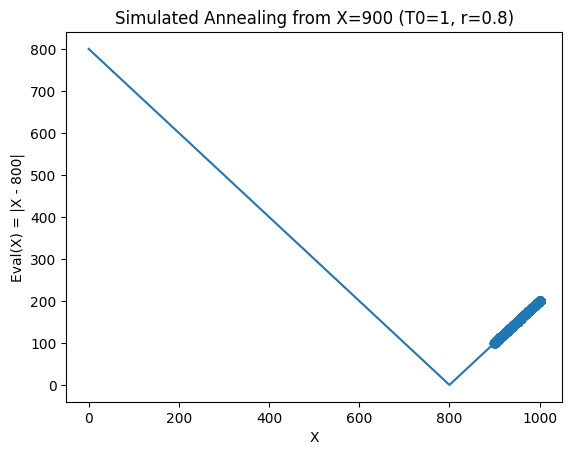

T after 20 steps: 0.011529215046068483
T after 200 steps: 4.149515568881039e-20


In [17]:
sa_final, sa_path, sa_temps = simulated_annealing(
    900, T0=1.0, r=0.8, steps=600, rng=random.Random(42))
print(f"SA from 900 (T0=1, r=0.8) -> final X={sa_final}, Eval={eval_abs800(sa_final)}, "
      f"steps={len(sa_path)-1}, final T={sa_temps[-1]:.3e}")
plot_trajectory(sa_path, "Simulated Annealing from X=900 (T0=1, r=0.8)")
print("T after 20 steps:", 1.0 * (0.8 ** 20))
print("T after 200 steps:", 1.0 * (0.8 ** 200))

### Q2(e) — Simulated Annealing result (600 steps)
Start X=900, T0=1, r=0.8 → final X=1000, score=200, final T≈7.15e−59.
After the temperature collapses, SA behaves like hill climbing and freezes at the local maximum X=1000.


## Q3(GA): Probability of optimal-at-init and crossover count

If one in 256 bitstrings is optimal and $N=1000$:

$$
P(\text{≥1 optimal}) = 1 - (1 - \tfrac{1}{256})^{1000} \approx 0.98, \quad E[\#optimal] \approx 3.9
$$

Thus, we likely already have optimal individuals at initialization ($N=0$ generations).  
For crossover:
- Single child per mating → $N$ matings = $N$ children  
- Two children per mating → $(N/2)$ matings = $N$ children


In [18]:
p_any, expected = ga_init_probability(pop_size=1000, optimal_rate=1/256)
print("P(at least one optimal at init):", p_any)
print("Expected #optimal at init:", expected)
print("Monte Carlo estimate (~2000 trials):", monte_carlo_any_optimal(
    trials=2000, pop_size=1000, optimal_rate=1/256))

P(at least one optimal at init): 0.9800374911305659
Expected #optimal at init: 3.90625
Monte Carlo estimate (~2000 trials): 0.9805


### Q3 (GA) — Probability of already having an optimal string
N=1000, p=1/256:
P(≥1 optimal) ≈ 0.9800,  E[#optimal] ≈ 3.906.  MC ≈ 0.9805.
So it’s very likely we already have optimal individuals at initialization (generation 0).


## Full Genetic Algorithm with live progress

We’ll:
1. Start with a random population of bitstrings.
2. Repeatedly apply selection, crossover, and mutation.
3. Track the best and average fitness each generation.
4. Optionally print example individuals and plot fitness curves.


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import random


def run_full_ga(
    population_size=20,
    chromosome_length=16,
    generations=40,
    mutation_rate=0.01,
    rng_seed=None,
    verbose=True,
    plot=True
):
    """Run the full GA and visualize its evolution."""
    rng = random.Random(rng_seed)
    pop = ["".join(rng.choice("01") for _ in range(chromosome_length))
           for _ in range(population_size)]

    avg_fits, best_fits = [], []

    for gen in range(generations):
        fits = [fitness_ones(x) for x in pop]
        best = max(fits)
        avg = float(np.mean(fits))
        avg_fits.append(avg)
        best_fits.append(best)

        if verbose:
            best_individual = max(pop, key=fitness_ones)
            print(
                f"Gen {gen:2d}: best_fit={best:2d} avg_fit={avg:5.2f}  best={best_individual}")

        if best == chromosome_length:
            print(f" Perfect individual found at generation {gen}!")
            break

        pop = ga_generate_successor(pop, mutation_rate, rng=rng)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(best_fits, label="Best fitness")
        plt.plot(avg_fits, label="Average fitness", linestyle="--")
        plt.xlabel("Generation")
        plt.ylabel("Fitness (# of 1s)")
        plt.title("GA evolution progress")
        plt.legend()
        plt.grid(True)
        plt.show()

    return pop, best_fits, avg_fits

Gen  0: best_fit=12 avg_fit= 7.93  best=0010011111111111
Gen  1: best_fit=13 avg_fit= 9.07  best=1101111111110101
Gen  2: best_fit=14 avg_fit= 9.33  best=1111101111101111
Gen  3: best_fit=14 avg_fit= 9.40  best=1111111111111001
Gen  4: best_fit=14 avg_fit= 9.37  best=1101111111111101
Gen  5: best_fit=15 avg_fit=10.23  best=1111111111101111
Gen  6: best_fit=15 avg_fit=10.87  best=1111111111101111
Gen  7: best_fit=14 avg_fit=11.13  best=1101111111101111
Gen  8: best_fit=14 avg_fit=11.47  best=1111011111110111
Gen  9: best_fit=14 avg_fit=11.67  best=1111111111110101
Gen 10: best_fit=15 avg_fit=11.73  best=1111111111111101
Gen 11: best_fit=15 avg_fit=12.37  best=1111111111110111
Gen 12: best_fit=15 avg_fit=12.00  best=1111111111101111
Gen 13: best_fit=15 avg_fit=12.37  best=1111111111101111
Gen 14: best_fit=15 avg_fit=12.83  best=1111111111101111
Gen 15: best_fit=15 avg_fit=12.70  best=1111111111110111
Gen 16: best_fit=15 avg_fit=12.33  best=1111111111110111
Gen 17: best_fit=15 avg_fit=11.

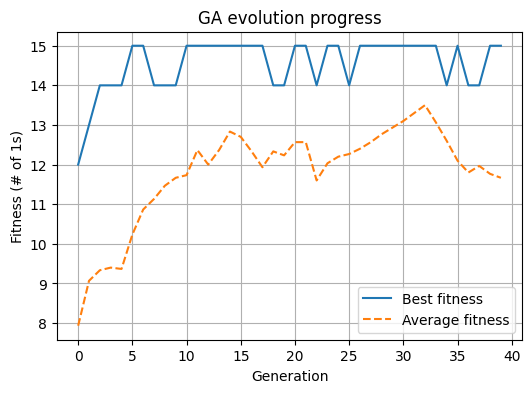

In [22]:
final_pop, best_curve, avg_curve = run_full_ga(
    population_size=30,
    chromosome_length=16,
    generations=40,
    mutation_rate=0.02,
    rng_seed=14
)

## Takeaways
- Many “different” search methods are GLS with different knobs.
- Hill Climb is fast but myopic; Random Walk explores but ignores quality.
- SA interpolates between them: exploratory when hot, greedy when cold.
- Beam Search keeps only the top-K frontier; GA explores a population via selection+crossover+mutation.
- On this toy landscape (maximize |X−800|), the attractors are X=0 (global max=800) and X=1000 (local max=200).
